# Electricity Demand Forecasting

Time Series Modeling<br>
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

This notebook contains the SARIMAX modeling for the weekly demand aggregated data.  The data was cleaned and aggregated in the EF_EDA_CleanSplitAgg notebook.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#import)<br>
2. [Data Import](#read_data)<br>
    2A. [Clean Data](#clean_data)<br>
    2B. [Extend Data](#extend_dow)<br>
    2C. [Data Split](#data_split)<br>
3. [Helper Functions](#helper)<br>
4. [Data Analysis](#analysis)<br>
    4A. [Stationarity Testing](#stationarity)<br>
    4B. [Autocorrelation](#autocorr)<br>
    4C. [Seasonal Decomposition](#seasonal_decomp)<br>
5. [Modeling](#modeling)<br>
    5A. [SARIMAX Without Exogenous Data](#SARI_NoX)<br>
    5A.1 [SARIMAX Without Exogenous Data Fit Plot 1](#plot-SARI_fit_zoom)<br>
    5A.2 [SARIMAX Without Exogenous Data Fit Plot 2](#plot-SARI_fit_wide)<br>
    5A.3 [SARIMAX Without Exogeneous Data - Forecast](#forecast-SARI_nox)<br>

    5B. [SARIMAX With Exogeneous Data](#model-SARIMAX-wexog)<br>
    5B.1 [SARIMAX With Exogeneous Data - Fit Plot Close](#plot-SARI_exog_fit_zoom)<br>
    5B.2 [SARIMAX With Exogeneous Data - Fit Plot 3 Month](#plot-SARI_exof_fit_wide)<br>
    5B.3 [SARIMAX With Exogeneous Data - Forecast](#forecast-SARI_exog)<br>

    5C. [SARIMAX With Extended Exogeneous Data](#model-SARI-xexog)<br>
    5C.1 [SARIMAX With Extended Exogeneous Data - Fit Plot Close](#plot-SARI_xexog_fit_zoom)<br>
    5C.2 [SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month](#plot-SARI_xexof_fit_wide)<br>
    5C.3 [SARIMAX With Extended Exogeneous Data - Forecast](#forecast-SARI_xexog)<br>




----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [39]:
import pandas as pd
import numpy as np
import re

import json
import datetime

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel
from statsmodels.tsa.stattools import adfuller
from collections import defaultdict


In [40]:
warnings.filterwarnings('ignore')

----
### 2. Data Import <a id='read_data'></a>

Read the data file created by the notebook EF_EDA_CleanSplitAgg.

----

In [41]:
data_file = '../data/big_demand_temp_train_by_week.csv'

In [42]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83,0.0
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60,0.0
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03,0.0
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40,0.0
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56,0.0


#### 2.A Clean the data frame <a id='clean_data'></a>

In [43]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2015-07-06 to 2017-10-30
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   week_demand  122 non-null    float64
 1   CA_pop       122 non-null    float64
 2   la_high      122 non-null    float64
 3   sd_high      122 non-null    float64
 4   sj_high      122 non-null    float64
 5   sf_high      122 non-null    float64
 6   sac_high     122 non-null    float64
 7   f_high       122 non-null    float64
 8   DOW          122 non-null    float64
dtypes: float64(9)
memory usage: 9.5 KB


In [44]:
full_df.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83,0.0
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60,0.0
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03,0.0
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40,0.0
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56,0.0


#### 2.B Extending Exogenous Regressors To Include Day Of Week <a id='extend_dow'></a>

In [45]:
new_df = full_df.drop('DOW', axis=1)

new_df.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56


----

#### 2.C Data Split <a id='data_split'></a>

----

In [46]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [47]:
# Split the data frame into two parts
train_len = int(0.6 * data_len)
window_len = int(0.13 * data_len)

In [48]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]


In [49]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2015-07-06 to 2016-11-21
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   week_demand  73 non-null     float64
 1   CA_pop       73 non-null     float64
 2   la_high      73 non-null     float64
 3   sd_high      73 non-null     float64
 4   sj_high      73 non-null     float64
 5   sf_high      73 non-null     float64
 6   sac_high     73 non-null     float64
 7   f_high       73 non-null     float64
dtypes: float64(8)
memory usage: 5.1 KB


In [50]:
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['week_demand'])


In [51]:
X_train.tail()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2016-10-24,4998192.0,13911737.0,81.35,80.34,79.15,68.47,78.09,83.80,15.424587
2016-10-31,4923159.0,13911737.0,86.26,77.12,74.70,70.78,73.61,76.89,15.409461
2016-11-07,5131645.0,13911737.0,93.09,93.61,78.05,73.52,76.26,83.08,15.450937
2016-11-14,4897298.0,13911737.0,87.53,83.86,70.18,64.58,73.51,76.66,15.404194
2016-11-21,4737510.0,13911737.0,79.03,76.49,63.73,59.76,61.00,61.10,15.371022


----

### 3. Helper Functions <a id='helper'></a>

----


In [52]:
import sys
sys.path.append('../src')
from EF_tools import test_stationarity, order_sweep, top_results

### 4. Data Analysis <a id='analysis'></a>

#### 4.1 Stationarity Testing <a id='stationarity'></a>

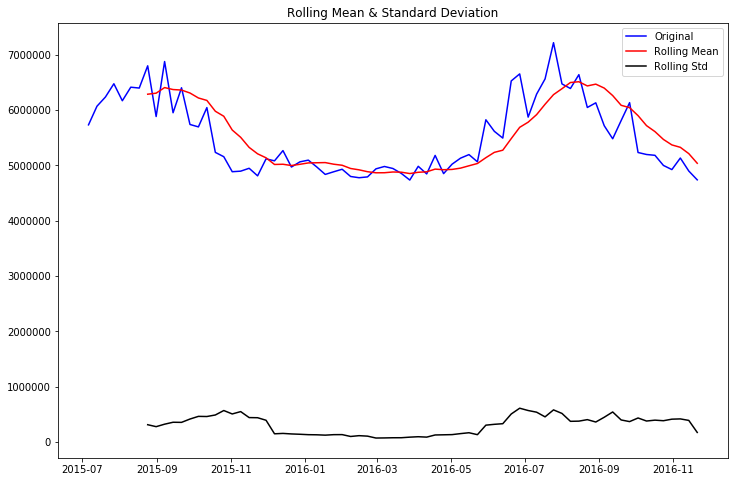

Results of Dickey-Fuller Test:
p-value = 0.6122. The series is likely non-stationary.
Test Statistic                 -1.336724
p-value                         0.612208
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [53]:
test_stationarity(X_train.week_demand, window=8)

Daily data is not stationary.  Try a simple difference to see if we can get a stationary result

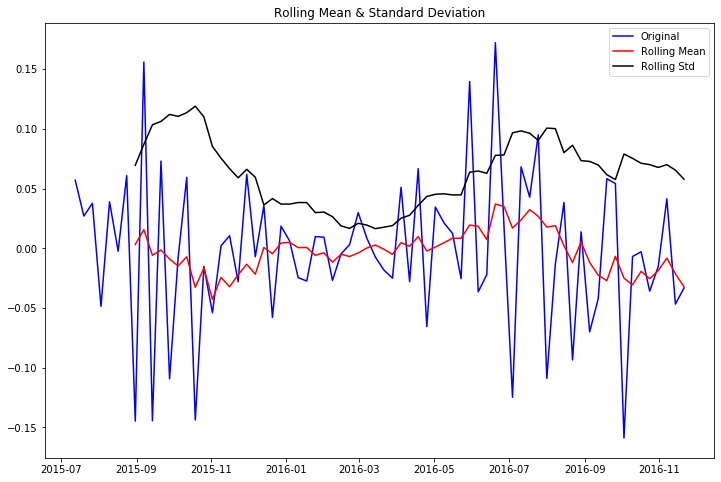

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.899242e+00
p-value                        4.228663e-12
#Lags Used                     1.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [54]:
diff_demand_day = X_train.week_demand.diff()[1:]
log_demand = np.log(X_train.week_demand)

test_stationarity(log_demand.diff()[1:], window=8)

#### 4.2 Autocorrelation <a id='autocorr'></a>

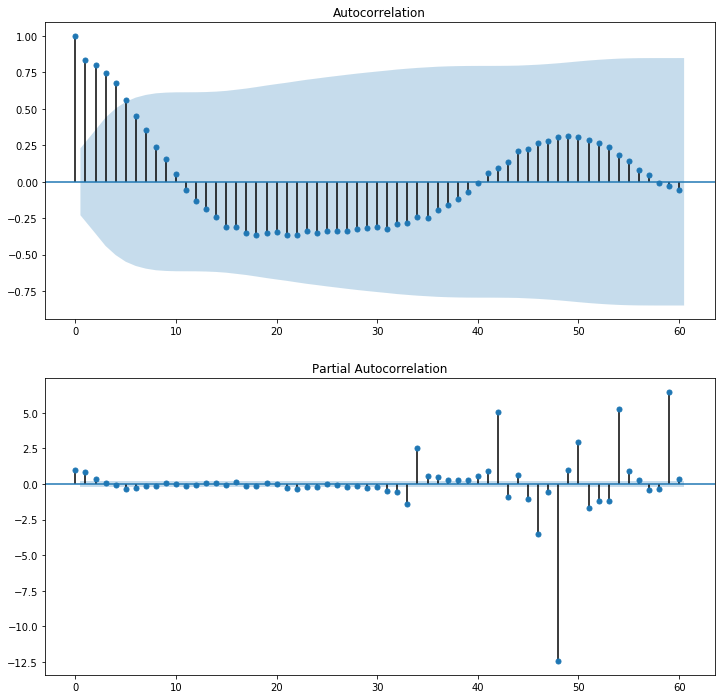

In [55]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_demand, lags=60, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_demand, lags=60, ax=ax2)# , lags=40

----

### 5. <a id='modeling'>Modeling </a>

In the following cells I do a number of model fits to find the 'best' parameters to include in the final model.

----

#### 5A. <a id='SARI_NoX'>SARIMAX Without Exogeneous Data </a>

In [56]:
# Define the model for SARIMAX just using the demand data
order_list =[(1,0,0),
             (2,0,0),
             (3,0,0),
             (4,0,0),
             (1,0,1),
             (2,0,1),
             (3,0,1),
             (4,0,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(0,0,0, 52),
                (1,0,0, 52),
                (2,0,0, 52)]

result_dict1 = order_sweep(SARIMAX, order_list, seasonal_list,  endo_data=X_train['log_demand'])

#res1 = seasonal_model1.fit()

In [57]:
for result in top_results(result_dict1, 'aic', 5) :
    print(result)


{'order': (2, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -187.98280651518618, 'bic': -178.8209687505926, 'mse': 3.320609362878462}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -186.3882923464462, 'bic': -174.93599514070425, 'mse': 3.320581551706225}
{'order': (1, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -185.79384030976635, 'bic': -174.3415431040244, 'mse': 3.3206111208431035}
{'order': (4, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -183.56553196501255, 'bic': -167.53231587697383, 'mse': 3.3205251454720592}
{'order': (1, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -173.57278696278988, 'bic': -164.4109491981963, 'mse': 3.3213593553046863}


In [58]:
for result in top_results(result_dict1, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (2, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -187.98280651518618, 'bic': -178.8209687505926, 'mse': 3.320609362878462}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -186.3882923464462, 'bic': -174.93599514070425, 'mse': 3.320581551706225}
{'order': (1, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -185.79384030976635, 'bic': -174.3415431040244, 'mse': 3.3206111208431035}
{'order': (3, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -185.610919372114, 'bic': -171.86816272522367, 'mse': 3.3205212373049}
{'order': (1, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -173.57278696278988, 'bic': -164.4109491981963, 'mse': 3.3213593553046863}


In [59]:
for result in top_results(result_dict1, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (4, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -181.55137319279802, 'bic': -163.2276976636109, 'mse': 3.3205300073274944}
{'order': (4, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -184.76624232701923, 'bic': -171.02348568012889, 'mse': 3.320572776096929}
{'order': (2, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -187.98280651518618, 'bic': -178.8209687505926, 'mse': 3.320609362878462}
{'order': (4, 0, 0), 'seasonal order': (0, 0, 0, 52), 'aic': -178.63638722403, 'bic': -167.18409001828803, 'mse': 3.32067133792104}
{'order': (3, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': 92.80777295552556, 'bic': 104.26007016126752, 'mse': 3.3210237433324528}


In [60]:
# Now choose the results that seem to work the best above and fit the model
# The top results above are further evaluated based on coefficient p-values
best_order1 = (2, 0, 1)
best_seasonal_order1 = (1, 0, 0, 52)
model1 = SARIMAX(log_demand, order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [61]:
print(res1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         week_demand   No. Observations:                   73
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 52)   Log Likelihood                 -38.793
Date:                             Tue, 07 Apr 2020   AIC                             87.585
Time:                                     16:21:06   BIC                             99.038
Sample:                                 07-06-2015   HQIC                            92.149
                                      - 11-21-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7062      0.082      8.662      0.000       0.546       0.866
ar.L2          0.2936      

In [62]:
res1.aic, res1.bic, res1.mse

(87.58533473848146, 99.03763194422342, 3.321455313092111)

In [63]:
# Save the trained model
filename = 'SARIMAX_wo_exog_week.sav'
pickle.dump(model1, open(filename, 'wb'))

In [64]:
demand_hat = np.exp(res1.fittedvalues)

----

##### 5A.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

----

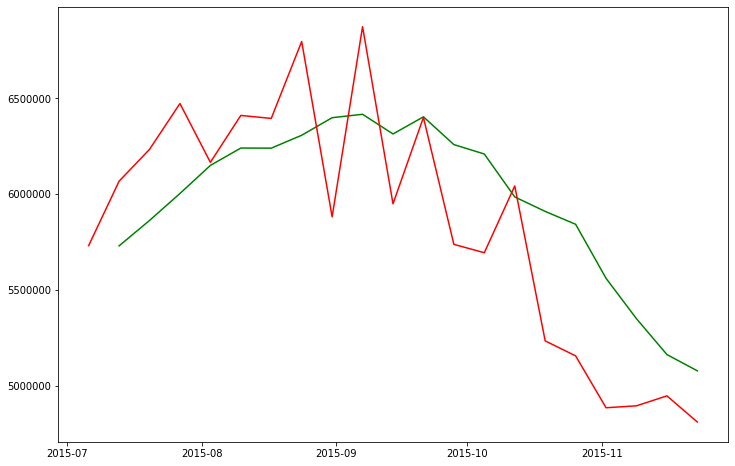

In [65]:
fig = plt.figure(figsize=[12, 8])
close_window = 3*7

plt.plot(demand_hat[1:close_window], label='Predicted', c='g')
plt.plot(X_train.index[:close_window], X_train['week_demand'].values[:close_window], c='r',\
    label='Actual (train)')

----

##### <a id='plot-SARI_fit_wide'>5A.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  </a>

----

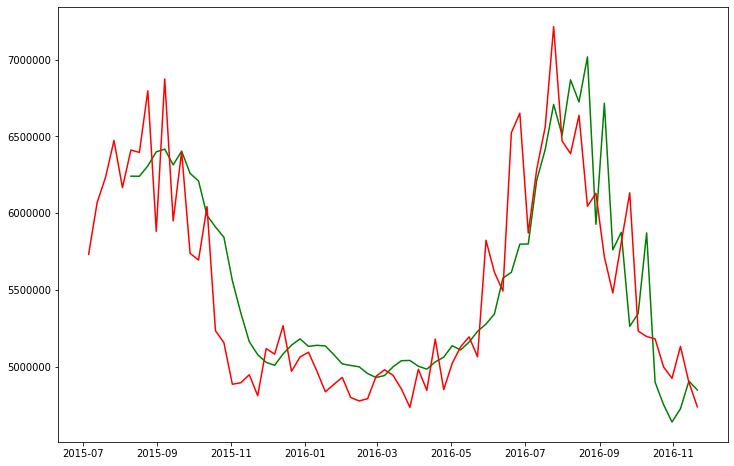

In [66]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat[5:1000], c='g')
plt.plot(X_train.index[0:1000], X_train['week_demand'].values[0:1000], c='r')

----

##### 5A.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [67]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

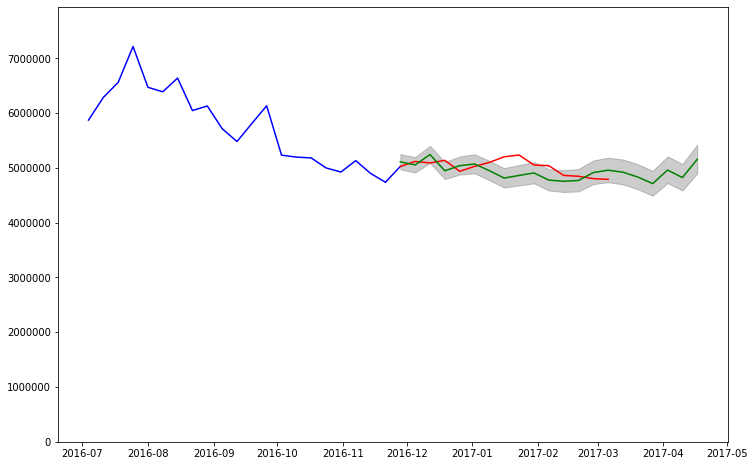

In [78]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk1['week_demand']))]))

plt.plot(X_train.index[-1*predict_steps:], X_train['week_demand'].values[-1*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['week_demand'].index[0]], \
          [X_train['week_demand'].values[-1], X_walk1['week_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['week_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

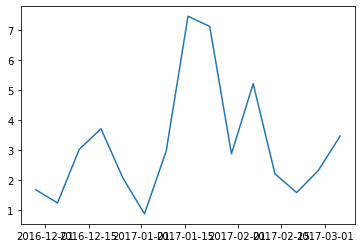

In [79]:
samp_len = min([len(X_walk1), len(pred_vals1)])
residuals = [abs(X_walk1['week_demand'].values[x] - pred_vals1.values[x]) / \
        X_walk1['week_demand'].values[x] * 100 for x in range(samp_len)]

plt.plot(pred_times1[:samp_len], residuals)
#plt.ylim(0, 7000)

In [80]:
mape1 = np.mean(residuals[3])
print(mape1)

3.7105197319416297


----

#### <a id='model-SARIMAX-wexog'>5B. SARIMAX With Exogeneous Data </a>

----

In [81]:
# The trailing columns are city temperatures and state population
important_cities = ['la_high',  'f_high']

In [82]:
# Define the model for SARIMAX just using the demand data
order_list =[(1,0,1),
             (2,0,1),
             (2,0,0),
             (3,0,0),
             (3,0,1),
             (4,0,0)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(1,0,0, 52),
                (2,0,0, 52)]

result_dict2 = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[important_cities])

#res1 = seasonal_model1.fit()

In [83]:
for result in top_results(result_dict2, 'aic', 5) :
    print(result)


{'order': (2, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -206.170824905641, 'bic': -190.13760881760228, 'mse': 2.989648767532437}
{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -200.1550224136603, 'bic': -179.54088744332478, 'mse': 3.0543199450890626}
{'order': (3, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -194.27135371893866, 'bic': -175.9476781897515, 'mse': 3.0578748968176948}
{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -193.26642884882793, 'bic': -179.5236722019376, 'mse': 3.060421370740771}
{'order': (1, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -101.97315203847036, 'bic': -85.93993595043162, 'mse': 2.7236750587038157}


In [84]:
for result in top_results(result_dict2, 'bic', 5) :
    print(result)


{'order': (2, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -206.170824905641, 'bic': -190.13760881760228, 'mse': 2.989648767532437}
{'order': (2, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -201.8948063982816, 'bic': -183.57113086909447, 'mse': 2.9998971219003883}
{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -200.1550224136603, 'bic': -179.54088744332478, 'mse': 3.0543199450890626}
{'order': (3, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -194.27135371893866, 'bic': -175.9476781897515, 'mse': 3.0578748968176948}
{'order': (1, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -101.97315203847036, 'bic': -85.93993595043162, 'mse': 2.7236750587038157}


In [85]:
for result in top_results(result_dict2, 'mse', 5) :
    print(result)


{'order': (1, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -101.97315203847036, 'bic': -85.93993595043162, 'mse': 2.7236750587038157}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -115.95134190111337, 'bic': -102.20858525422302, 'mse': 2.72430474428094}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -115.95134190111337, 'bic': -102.20858525422302, 'mse': 2.72430474428094}
{'order': (4, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -136.4668233277883, 'bic': -118.14314779860116, 'mse': 2.920656135317428}
{'order': (3, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -158.67806421906423, 'bic': -140.3543886898771, 'mse': 3.0401256584401533}


In [102]:
# Now choose the results that seem to work the best above and fit the model
# The top results from above are further evaluated based on coefficient p-values
best_order2 = (3, 0, 1)
best_seasonal_order2 = (1, 0, 0, 52)
model2 = SARIMAX(X_train['log_demand'], order=best_order2, seasonal_order=best_seasonal_order2, \
            exog=X_train[important_cities])
res2 = model2.fit()

In [103]:
print(res2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                   73
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood                 105.136
Date:                             Tue, 07 Apr 2020   AIC                           -194.271
Time:                                     16:37:26   BIC                           -175.948
Sample:                                 07-06-2015   HQIC                          -186.969
                                      - 11-21-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0026      0.001      3.287      0.001       0.001       0.004
f_high         0.0043      

In [104]:
# Save the trained model
filename = 'SARIMAX_w_exog_week.sav'
pickle.dump(model2, open(filename, 'wb'))

In [105]:
res2.aic

-194.27135371893866

In [106]:
demand_hat2 = np.exp(res2.fittedvalues)

----
##### 5B.1 <a id='plot-SARI_exog_fit_zoom'>SARIMAX With Exogeneous Data - Fit Plot Close </a>
----

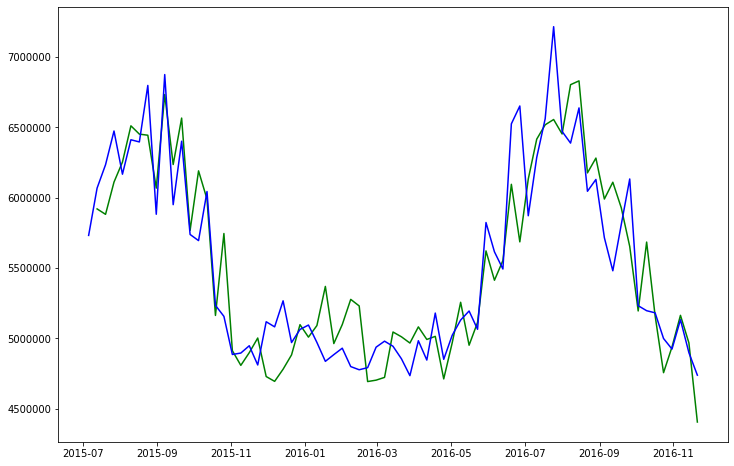

In [107]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat2[1:], c='g')
plt.plot(X_train.index, X_train['week_demand'].values, c='b')

----

##### <a id='plot-SARI_exof_fit_wide'>5B.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month </a>

----

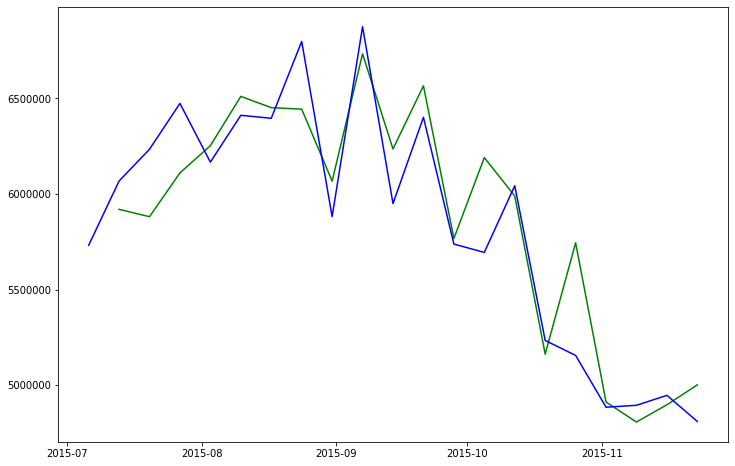

In [108]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat2[1:21], label='Prediction', c='g')
actual = X_train['week_demand'].values
plt.plot(X_train.index[:21], X_train['week_demand'].values[:21], label='Actual', c='b')

----
##### <a id='forecast-SARI_exog'>5B.3 SARIMAX With Exogeneous Data - Forecast  </a>
----

In [109]:
predict_steps = 13
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = np.exp(predict2.conf_int(alpha=0.5))
pred_vals2 = np.exp(predict2.predicted_mean)

In [110]:
aic2 = res2.aic

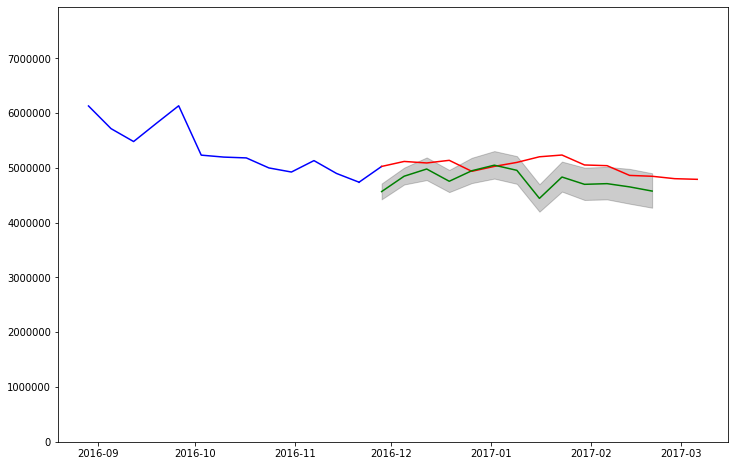

In [113]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk1['week_demand']))]))

plt.plot(X_train.index[-1*predict_steps:], X_train['week_demand'].values[-1*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['week_demand'].index[0]], \
          [X_train['week_demand'].values[-1], X_walk1['week_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['week_demand'].values, c='r')
plt.plot(pred_times2, pred_vals2.values, c='g')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2)

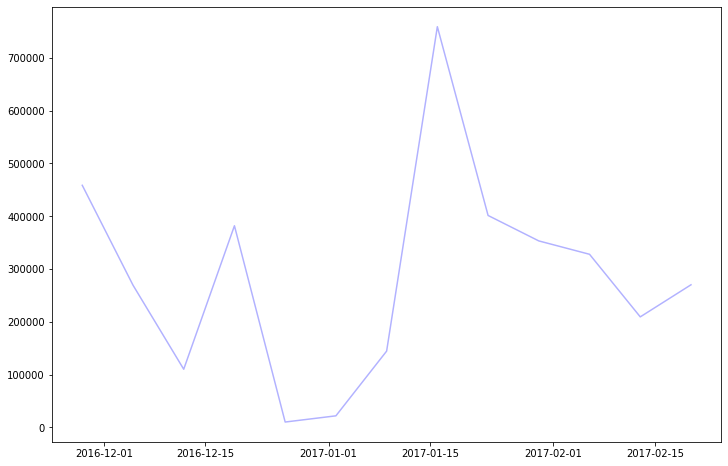

In [114]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['week_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)
#plt.ylim(0, 10000)

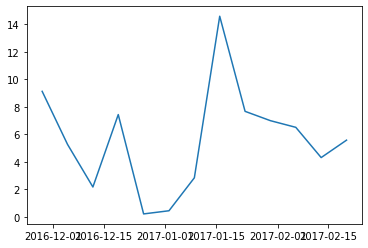

In [115]:
samp_len = min([len(X_walk1), len(pred_vals2)])
residuals2 = [abs(X_walk1['week_demand'].values[x] - pred_vals2.values[x])/ \
             X_walk1['week_demand'].values[x]*100 for x in range(samp_len)]
plt.plot(pred_times2[:samp_len], residuals2)


In [116]:
mape2 = np.mean(residuals2[:3])
print(mape2)

5.52134102465141


----
#### <a id='model-SARI-xexog'>5C. SARIMAX With Extended Exogeneous Data </a>
----

In [117]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_columns = X_train.columns[1:-1]
all_exog_columns = ['CA_pop', 'la_high', 'f_high']

In [118]:
# Define the model for SARIMAX just using the demand data
order_list =[(1,0,1),
             (2,0,1),
             (2,0,0),
             (3,0,0),
             (3,0,1),
             (4,0,0)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(1,0,0, 52),
                (2,0,0, 52)]

result_dict3 = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[all_exog_columns])


In [119]:
for result in top_results(result_dict3, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -230.6778336058791, 'bic': -214.64461751784037, 'mse': 0.0020347742161699995}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -229.65978321991165, 'bic': -213.62656713187292, 'mse': 0.00206520675888868}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -228.96896432061092, 'bic': -210.6452887914238, 'mse': 0.0020267238487718725}
{'order': (3, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -228.7650453674393, 'bic': -210.44136983825217, 'mse': 0.002033486451409586}
{'order': (2, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -226.9782901378733, 'bic': -206.36415516753777, 'mse': 0.002027253436073084}


In [120]:
for result in top_results(result_dict3, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -230.6778336058791, 'bic': -214.64461751784037, 'mse': 0.0020347742161699995}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -229.65978321991165, 'bic': -213.62656713187292, 'mse': 0.00206520675888868}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -228.96896432061092, 'bic': -210.6452887914238, 'mse': 0.0020267238487718725}
{'order': (3, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -228.7650453674393, 'bic': -210.44136983825217, 'mse': 0.002033486451409586}
{'order': (2, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -226.9782901378733, 'bic': -206.36415516753777, 'mse': 0.002027253436073084}


In [121]:
for result in top_results(result_dict3, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (4, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -225.87579212983402, 'bic': -202.9711977183501, 'mse': 0.0020023258556642605}
{'order': (4, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -227.69215962507303, 'bic': -207.0780246547375, 'mse': 0.0020072296909451138}
{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -225.10279635179873, 'bic': -202.19820194031482, 'mse': 0.0020235024443827094}
{'order': (3, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -226.82541688083887, 'bic': -206.21128191050335, 'mse': 0.0020311999335998728}
{'order': (3, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -228.7650453674393, 'bic': -210.44136983825217, 'mse': 0.002033486451409586}


In [124]:
# Now choose the results that seem to work the best above and fit the model
best_order3 = (3, 0, 1)
best_seasonal_order3 = (1, 0, 0, 52)
model3 = SARIMAX(X_train['log_demand'], order=best_order3, seasonal_order=best_seasonal_order3,\
            exog=X_train[all_exog_columns])
res3 = model3.fit()

In [125]:
print(res3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                   73
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood                 122.413
Date:                             Tue, 07 Apr 2020   AIC                           -226.825
Time:                                     16:39:40   BIC                           -206.211
Sample:                                 07-06-2015   HQIC                          -218.610
                                      - 11-21-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA_pop      1.067e-06    6.7e-09    159.262      0.000    1.05e-06    1.08e-06
la_high        0.0021      

In [126]:
demand_hat3 = np.exp(res3.fittedvalues)

----
##### <a id='plot-SARI_xexog_fit_zoom'>5C.1 SARIMAX With Extended Exogeneous Data - Fit Plot Close </a>
----

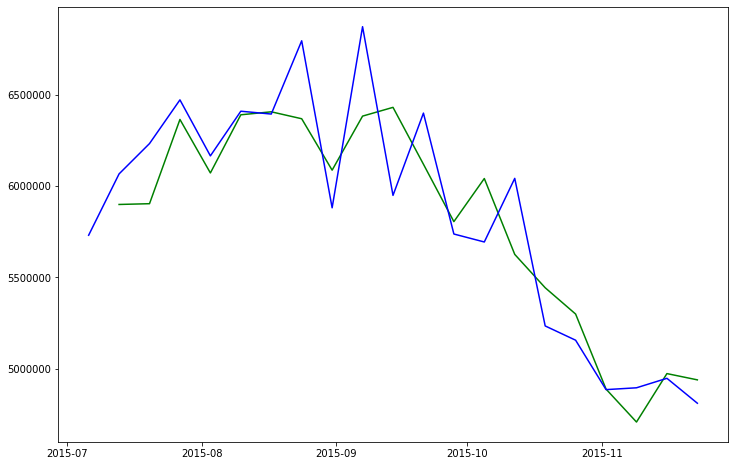

In [127]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat3[1:21], label='Prediction', c='g')
actual = X_train['week_demand'].values
plt.plot(X_train.index[:21], X_train['week_demand'].values[:21], label='Actual', c='b')

----

##### <a id='plot-SARI_xexof_fit_wide'>5C.2 SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month </a>

----

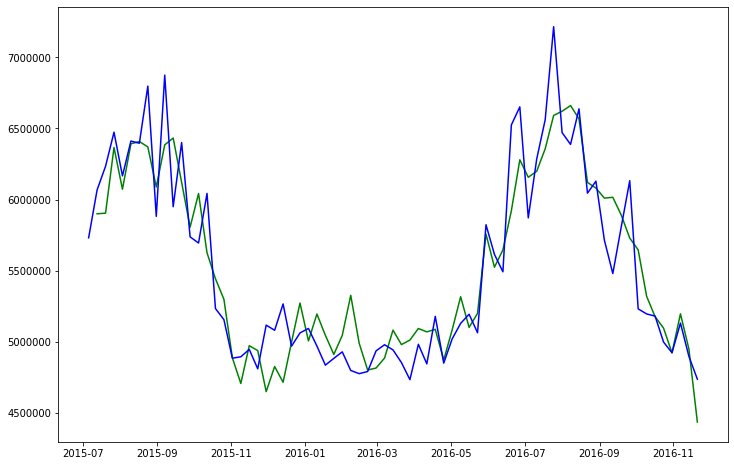

In [128]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat3[1:], c='g')
plt.plot(X_train.index, X_train['week_demand'].values, c='b')

In [129]:
# Save the trained model
filename = 'SARIMAX_w_xexog_week.sav'
pickle.dump(model3, open(filename, 'wb'))

In [130]:
X_train.tail()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2016-10-24,4998192.0,13911737.0,81.35,80.34,79.15,68.47,78.09,83.80,15.424587
2016-10-31,4923159.0,13911737.0,86.26,77.12,74.70,70.78,73.61,76.89,15.409461
2016-11-07,5131645.0,13911737.0,93.09,93.61,78.05,73.52,76.26,83.08,15.450937
2016-11-14,4897298.0,13911737.0,87.53,83.86,70.18,64.58,73.51,76.66,15.404194
2016-11-21,4737510.0,13911737.0,79.03,76.49,63.73,59.76,61.00,61.10,15.371022


In [131]:
X_walk1.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high
2016-11-28,5025013.0,13911737.0,71.95,72.32,64.80,61.63,58.25,59.55
2016-12-05,5116373.0,13911737.0,65.87,65.85,65.39,61.34,61.30,67.17
2016-12-12,5088765.0,13911737.0,70.58,70.06,62.86,60.46,62.56,67.36
2016-12-19,5136727.0,13911737.0,76.94,77.12,64.32,61.26,59.27,56.19
2016-12-26,4936362.0,13996299.0,80.49,82.23,62.01,59.05,57.06,59.39


In [132]:
predict_steps = 13
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[all_exog_columns].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

No handles with labels found to put in legend.


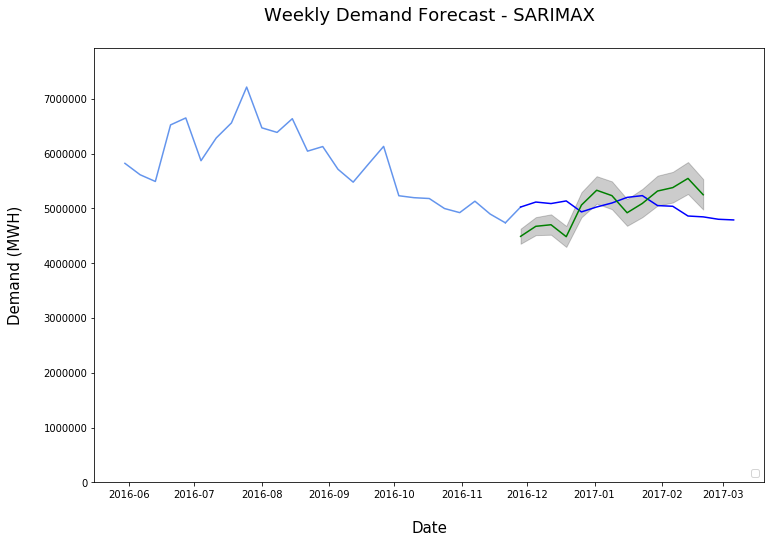

In [134]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Weekly Demand Forecast - SARIMAX\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk1['week_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], \
         X_train['week_demand'].values[-2*predict_steps:], c='cornflowerblue')
plt.plot([X_train.index[-1], X_walk1['week_demand'].index[0]], \
        [X_train['week_demand'].values[-1], X_walk1['week_demand'].values[0]], c='cornflowerblue')
plt.plot(X_walk1.index, X_walk1['week_demand'].values, c='b')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)
plt.savefig('weekly_demand_forecast_xwalk-sarima.png', Transparent=True)

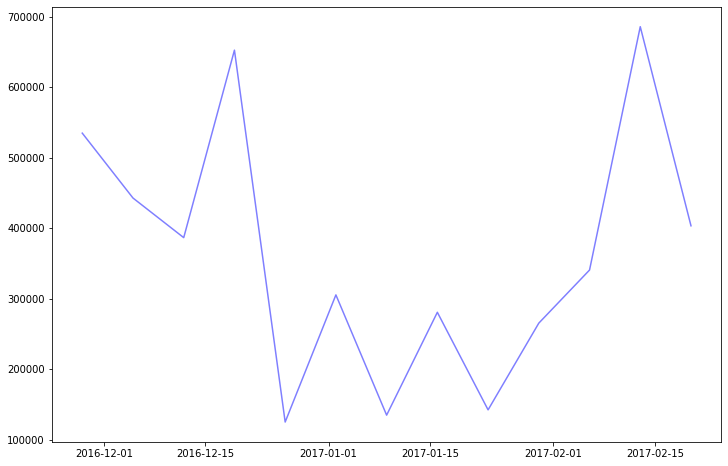

In [135]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['week_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
plt.plot(pred_times3, residuals3, c='b', alpha=0.5)
#plt.ylim(0, 10000)

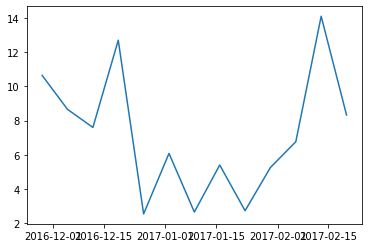

In [136]:
samp_len = min([len(X_walk1), len(pred_vals3)])
residuals = [abs(X_walk1['week_demand'].values[x] - pred_vals3.values[x]) for x in range(samp_len)]
percent_error = [residuals[x]/X_walk1['week_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3[:samp_len], percent_error)


In [139]:
mape3_3 = np.mean(percent_error[:3])
print(mape3_3)

8.964814786842819
